# FOREX Project - Market Simulation

This notebook is an accompaniment to marketplace.py and aims to describe the underlying assumptions and models that the marketplace simulation is based on. The structure is as follows:

    1. Project Brief 
    2. Modelling the FOREX rate - discussion of various ways to model the fluctuations in the exchange rate
    3. Modelling P2P Marketplace
    4. Summary

# 1. Project Brief

*The aim of this project is twofold, first of all to simulate a p2p marketplace and an exchange rate. Secondly, to use your datasets to build a model to predict the probability orders would be matched and evaluate the model. In a p2p marketplace, a user can either be a buyer and take the rate on offer, or a seller and offer their own rate and wait.*

*Part 1. Simulation:*

*Simulate a P2P marketplace for two currencies. This involves firstly simulating the exchange rate over time and then simulating a marketplace with users buying and selling either currency.*

    1. Assumptions:

        1. Pick a starting rate and simulate it fluctuating over time

        2. The frequency and average size of trades differ on either side of the market, i.e. there are more trades selling one currency than the other

        3. The system always offers an amount at a rate 0.05% below the exchange rate

    2. Outline dataset 1:

        1. Currency Sell

        2. Currency Buy

        3. Rate

        4. Timestamp

    3. Outline dataset 2:

        1. TradeID

        2. TimestampPlaced

        3. TimestampMatched

        4. TradeAmount

        5. RateOrdered

        6. TradeAmontMatched

        7. MatchedTradeID

*Part 2. Prediction:*

*Use your datasets and any other information to predict whether the trades placed by users will be matched with 1,2,3,4,..,7 days. Fit the model and evaluate its performance.*

# 2. Modelling FOREX rate

The first assumption we must make about our simulation is how the exchange rate will fluctuate over time. In this project, three different methods will be used - fixed/constant, sinuosoidal and geometric Brownian motion. The first one is self-explanatory and doesn't vary over time. This is useful if we want to look at the effects of other initial parameters on the market behaviour, and these will be covered shortly. The second method is a simple periodic sine oscillation, which is parametrised by a period selected in marketplace.py. The third method, geometric Brownian motion, is more realistic but more complicated to model. The remainder of this section will be devoted to explaining it.

Geometric Brownian motion is a stochastic process, always non-negative, and finds use throughout many fields. Most importantly it's the best formula for modelling stock prices in Finance, and will work well modelling the time variations of the exchange rate. Mathematically speaking, the new rate $x$ after a time step $\Delta t$ which had initial rate $x_0$ is given by
$$ x = x_0 e^{(\mu - \frac{\sigma^2}{2})\Delta t + (\sigma W(\Delta t))} $$
where $\mu$ is the 'drift factor', $\sigma$ the volatility and $W(\Delta t)$ is the Wiener process. Below is a short piece of code which implements GBM in Python. To illustrate the inherent randomness of the model, a plot is shown of 5 different market simulations which had the same starting parameters but show drastically different time evolutions.

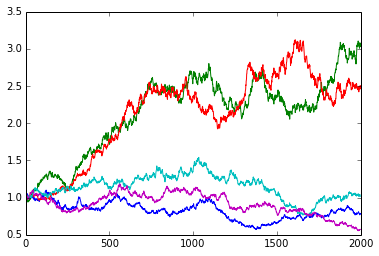

In [4]:
import numpy as np
import matplotlib.pylab as plt
import random
%matplotlib inline

# forex params
dt = 1.0   # Time step
mu = 0.00025  # drift factor
sigma = 0.01 # volatility

iters = 2000 # Number of iterations
initial_price = 1.0 # initial USD to EUR price
total_time = iters*dt # Total time

def forex_update(price):
    ### update FOREX price using geometric Brownian motion
    W = np.random.standard_normal() 
    W = np.cumsum(W)*np.sqrt(dt)
    x = (mu-0.5*sigma**2)*dt+(sigma*W) 
    return price*np.exp(x)
    
time_span = np.arange(0,total_time,dt)

for market in range(5):
    
    historic_data = np.array([])
    price = initial_price
    for t in time_span:  # Time step
        historic_data = np.append(historic_data, price)
        price = forex_update(price)
    
    plt.plot(time_span, historic_data)  
plt.show()

This code, along with ones for the constant rate and the sine rate are used in the main program marketplace.py

# 3. Modelling P2P Marketplace

Now we need to model the mechanisms of a P2P marketplace, with buyers and sellers of both currencies. The pseudocode for the simulation goes as follows:

    1. Initialise parameters for FOREX, number of buyers/sellers, length of simulation etc.
    2. Begin simulation (iterative loop)
        i. Create a vector of buyers and dictionary of NEW sellers (see Part A below)
        ii. Add new sellers to existing sellers dictionary
        iii.Complete trades between buyers/sellers                 (see Part B below)
        iv. clean up sellers dictionary
                - Move sellers who have sold all their currency to a separate "success" dict
                - Sellers who have not finished selling before hitting a "cutoff" number of days are 
                  moved to an "unsuccessful" dict
        v. FOREX rate is updated and the next market iteration begins
    3. Output recorded data into four pandas data frames for future analysis
        i. Market parameters used
        ii. FOREX rate information (USD to EUR over time)
        iii. Successful sellers information
        iv. Unsuccessful sellers information

This whole process is also outlined in the raw python file accompanying this notebook, as well as detailed comments used throughout. The parts requiring most detail are 2.i. and 2.iii. concerning the creation of traders and the completion of currency exchanges between them. These will be detailed in this section, which is split up into two parts. Part A deals with how the amounts and rates of the individual buyers and sellers are obtained. Part B concerns the actual currency trading.

## 2. A. Quantifying Buying / Selling rates

The first thing to consider when modelling the buyers and sellers in the market are
    2. A. 1. Trading Amounts
    2. A. 2. Requested Rate (Seller only)
and the frequency. Frequency can be determined by simply selecting a different number of buyers and sellers in each market. Figuring out the Trading Amounts and the Requested rate is a bit more involved - we can't just choose it randomly, instead we need to figure out a realistic way to determine them. In the next two subsections this will be explained.

### 2. A. 1. Trading Amounts

The best way to model this is to randomly sample from a probability distribution. We'll use a log-norm distribution with a large standard deviation as: it can only take positive values; has a 'long tail' (i.e. very large amounts still possible); and starts at zero. It should be emphasised that this is a purely heuristic model but seems intuitive - traders probably wouldn't bother trading very small amounts of currency, but the majority of them also won't be likely to transfer huge sums of it either. A plot showing two example log-norm probability distributions is shown below with means $$\mu = 8$$ (black) and $$\mu = 10$$ (red). Using the slider we can see the effect that the standard distribution $\sigma$ has on the probability distributions.

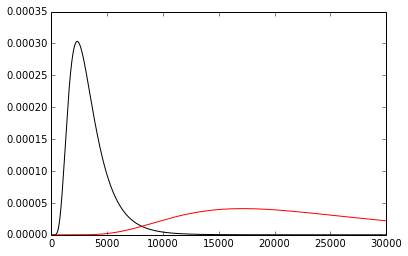

In [5]:
from IPython.html.widgets import *
from scipy.stats import lognorm


def pltln(sigma):
    logn_1 = lognorm(s=sigma, scale = np.exp(8.0));
    logn_2 = lognorm(s=sigma, scale = np.exp(10.0));
    rng = np.arange(0.1,30000.0,1.0)
    plt.plot(rng,logn_1.pdf(rng),'k')
    plt.plot(rng,logn_2.pdf(rng),'r')
    plt.show()
    
interact(pltln, sigma =(0.5,2.1,0.1))

This is really useful for us as we can capture two drastically different market behaviours - one buying/selling large volumes of small amounts, and another buying/selling at smaller volumes but distributed over a much larger range. It will be assumed over the time span that the market is iterated that these distributions won't change.

### 2. A. 2. Requested Rates

When sellers come to the marketplace they have the benefit of being able to select their own exchange rate. Some may choose a 'bad' rate for themselves, equating to a 'good' rate for the prospective buyers, in order to push their sale to the top of the marketplace with the hope that it'll sell quicker. Others may want to try and maximise their gain, pursuing a better rate for themselves which will be less attractive to the buyers.

Clearly, different sellers will have different motivations and this will affect the likelehood of a successful sale. It is the goal of this project to predict the probability of the number of days it takes a seller to make a successful trade. It serves us well to have a lot of trading data so for this reason a Gaussian (normal) distribution will be used with a mean value equal to the current market rate and a standard deviation of around 1% of this rate. Below is a short piece of code and plot that demonstrates this, and this is used in marketplace.py.

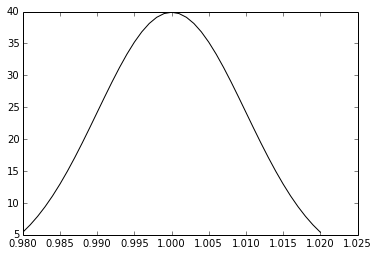

In [6]:
from scipy.stats import norm

initial_price = 1.0

norm_1 = norm(initial_price,initial_price/100.0);
rng = np.arange(initial_price*(1-2/100.0),initial_price*(1+2/100.0),0.001)
plt.plot(rng,norm_1.pdf(rng),'k')
plt.show()

# 2. B. - Simulating Trading

We now need to integrate the above into a simulated marketplace of buyers and sellers trading the currencies. This section is split into parts B.1. which explains how the buyers and sellers are initialised, and B.2. detailing the actual trading.

### 2. B. 1. Initialising buyers and sellers

Using the results of Part A we can populate a vector of buyer amounts and a dictionary of sellers each with an associated dictionary of their attributes, e.g. amounts, rates, unique ID and days selling. The various attributes are defined using the information in the previous sections. When selecting the number of buyers and sellers, this can either be fixed at a number N or picked from a gaussian distribution around N. This is chosen in a separate function which initialises the various parameters used in the program (e.g. FOREX rate type, number of iterations, standard deviations etc.). If a Gaussian is chosen the number of buyers and sellers changes with each market iteration. Below is an excerpt from marketplace.py that does this.

In [5]:
def whos_trading(rate,param_dic,sell_dic,currency,timestamp):
    """
    Initialises and returns buyers and sellers for a select currency

    Args:
        rate       (float) : current FOREX rate
        param_dic  (dic)   : dictionary of simulation parameters
        sell_dic   (dic)   : current dictionary of all market sellers
        currency   (str)   : selected currency ('usd' or 'eur')
        timestamp  (int)   : current time

    Returns:
        buyers(numpy arr.)  : 1D vector of buyer amounts in selected currency
        sell_dic    (dic)   : updated version of input sell_dic with new sellers
    """
    # Select a number of buyers and sellers
    curr_str = currency.upper() #convert currency to uppercase
    n = param_dic['N_'+curr_str] # number of buyers/sellers requested
    if param_dic['N_TYPE'] == 'fixed':      # Fixed number of buyers and selllers
        n_buyers = n  
        n_sellers = n
    elif param_dic['N_TYPE'] == 'gaussian': # Random number of buyers/sellers
        n_buyers = int(np.abs(              # using Gaussian distribution
            np.random.normal(n,param_dic['N_STD'])))    
        n_sellers = int(np.abs(
            np.random.normal(n,param_dic['N_STD']))) 

    # Initialise the buyers vector
    buyers = np.random.lognormal(param_dic['MU_'+curr_str],
                                 param_dic['SD_'+curr_str], n_buyers)

    # Initialise sellers dict
    for _ in range(n_sellers):
        # Create unique key
        if len(sell_dic) == 0:  # Safe check for first seller in simulation
            key = 0
        else:                   
            key = max(sell_dic.keys(), key=int) + 1
        # Create dictionary of attributes for this seller
        sell_dic[key] = {
                    'Currency'        : curr_str,        # Seller currency
                    'Day Advertised'  : int(timestamp),  # Day sale created
                    'Day Tracker'     : [],              # Tracks days on market
                    'Sale Tracker'    : [],              # Tracks amount
                    # Choose a rate using gaussian around current interbank
                    'Rate Offered'    : np.random.normal(
                                            rate,rate/param_dic['RATES_STD']),
                    # Chooses initial amount using lognorm distribution
                    # (see ipython notebook)
                    'Initial Amount'  : np.random.lognormal(
                                            param_dic['MU_'+curr_str],
                                            param_dic['SD_'+curr_str]),
                     }
        # Creates the seller's purse in order to keep separate from tracking data
        sell_dic[key]['Current Amount'] = sell_dic[key]['Initial Amount']

    return buyers, sell_dic

### 2. B. 2. Trading

With the buyers and sellers in both currencies initialised using the above function we can now complete the trades. A function very similar to that found in the full python code is shown below that will do this. Because there are a large number of possible variables that can affect the trading rates it will serve us best to optimise the routine as much as possible to aid speed of computation, and so we can try out different combinations of initial variables. For this reason dictionaries have been used for their quick operation times and clarity in code functionality.

This function works as follows.

In [6]:
def do_trades(b_to_s_rate,buyers,sellers_dic,day,sell_currency):
    """
    Completes all trades between buyers in one currency and 
    sellers in another, with exchange rate b_to_s_rate between
    buyer -> seller currencies.
    This function is called twice per iteration in __main__ for
    each combination of buyers and sellers

    Args:
        b_to_s_rate (float) : FOREX rate between buyers -> sellers currencies 
        buyers (numpy arr.) : 1D array of buyer amounts in own currency
        sellers_dic   (dic) : seller dictionary of all sellers
        day           (int) : today's timestamp
        sell_currency (str) : currency of the sellers
    Returns:
        unsold_buyers (list): list of unsold buyer amounts
        sellers_dic   (dic) : updated seller dictionary
    """
    # company will do trade at 0.5% b_to_s_rate if no suitable trade found
    # so we consider sellers that offer rates better than that only
    company_b_to_s = b_to_s_rate*(0.995)
    company_s_to_b = 1.0/company_b_to_s

    # for speed, take subset of sellers_dictionary of sellers who
    # have competetive rates better than company offer
    competetive_sellers = {key: val for key, val in sellers_dic.items()
                             if val['Rate Offered'] < company_s_to_b
                             and val['Currency'] == sell_currency}

    # convert this to an array for safety - we don't want to change dict
    # while iterating over it later
    seller_array = []
    for key,value in sorted( \
            competetive_sellers.items(),key=lambda x: x[1]['Rate Offered']):
        rate   =   competetive_sellers[key]['Rate Offered']
        amount =   competetive_sellers[key]['Current Amount']
        seller_array.append([key,rate,amount])

    # iterate through buyer list
    for buyer_idx in range(len(buyers)):
        # iterate through array of competetive sellers 
        for row_n in range(len(seller_array)):
            seller_id , seller_rate, seller_amount = seller_array[row_n]
            buyer_amount = buyers[buyer_idx]
            # calculate trade amount in seller currency
            trade_amount =  seller_amount - buyer_amount/seller_rate
            # if seller has enough money, remove amount from purse
            if trade_amount  >= 0.0:      
                seller_array[row_n][2] -= buyer_amount/seller_rate
                buyers[buyer_idx] = 0.0     # set buyer amount to 0
                break
            # elif seller has no money, set their purse to zero and update buyer 
            elif trade_amount < 0.0:
                seller_array[row_n][2] = 0.0
                buyers[buyer_idx] -= seller_amount*seller_rate

    # update successful seller details in sellers_dic
    for row_n in range(len(seller_array)):
        key , seller_rate, seller_amount = seller_array[row_n]
        sellers_dic[key]['Current Amount'] = seller_amount
        sellers_dic[key]['Sale Tracker'].append(seller_amount)  
        sellers_dic[key]['Day Tracker'].append(t)

    # Update uncompetetive sellers also to track their Days and Sales 
    for key in {key: val for key, val in sellers_dic.items() \
                     if val['Rate Offered'] >= company_s_to_b \
                     and val['Currency'] == sell_currency}:
        sellers_dic[key]['Sale Tracker'].append(
            sellers_dic[key]['Current Amount'])
        sellers_dic[key]['Day Tracker'].append(t)

    unsold_buyers =  [x for x in buyers if x != 0.0]

    return unsold_buyers , sellers_dic


# 4. Summary

The reader is encouraged to read through marketplace.py to see how the mechanisms of the market discussed in this notebook have been implemented. The next part of the project is devoted to an exploration of the data output by marketplace.py for different input parameters (e.g. which FOREX model was used). For this part, please see the notebooks in the /exploration/ directory.